Cell 1: Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


Cell 2: Load and Prepare Dataset

In [ ]:
# Load your dataset
csv_file_path = '/content/drive/MyDrive/RESEARCH-ALL-in-one/ALL-Data-in-one-CSV/best-dataset/dambulla_market_dataset.csv'
df = pd.read_csv(csv_file_path)

# Convert date and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Columns: {list(df.columns)}")

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (2017, 46)
Date range: 2020-01-01 00:00:00 to 2025-07-11 00:00:00
Columns: ['carrot_price', 'is_market_open', 'is_dambulla_increase', 'dambulla_demand', 'dambulla_is_trading_activities_high_or_low', 'bandarawela_mean_precipitation_mm', 'jaffna_mean_precipitation_mm', 'kandapola_mean_precipitation_mm', 'nuwaraeliya_mean_precipitation_mm', 'ragala_mean_precipitation_mm', 'bandarawela_mean_precipitation_mm.1', 'hanguranketha_mean_precipitation_mm', 'kalpitiya_mean_precipitation_mm', 'kandy_mean_precipitation_mm', 'mandaramnuwara_mean_precipitation_mm', 'marassana_mean_precipitation_mm', 'mathale_mean_precipitation_mm', 'pussellawa_mean_precipitation_mm', 'puttalam_mean_precipitation_mm', 'thalawakale_mean_precipitation_mm', 'walimada_mean_precipitation_mm', 'yatawatta_mean_precipitation_mm', 'Lp_95', 'Lp_92', 'lad', 'lsd', 'lk', 'lik', 'fur_800', 'fur_1500_high', 'fur_1500_Low', 'nuwaraeliya_supply_factor', 'jaffna_supply_factor', 'ragala_supply_factor', 'kandapola_supply_f

Cell 3: Select Target and Exogenous Variables

In [ ]:
# Define target variable
target_var = 'carrot_price'

# Select exogenous variables based on your earlier analysis
exog_variables = [
    'nuwaraeliya_mean_precipitation_mm',    # Weather - main growing region
    'kandapola_mean_precipitation_mm',      # Weather - secondary region
    'bandarawela_mean_precipitation_mm',    # Weather - secondary region
    'nuwaraeliya_supply_factor',           # Supply from main region
    'dambulla_demand',                     # Market demand
    'dambulla_is_trading_activities_high_or_low',  # Market activity
    'is_dambulla_increase'                 # Price trend indicator
]

# Extract clean data (remove rows with missing target values)
clean_data = df[[target_var] + exog_variables].dropna()

print(f"Clean dataset shape: {clean_data.shape}")
print(f"Rows removed due to missing values: {len(df) - len(clean_data)}")

# Separate target and exogenous variables
endog = clean_data[target_var]
exog = clean_data[exog_variables]

print(f"\nTarget variable: {target_var}")
print(f"Exogenous variables: {len(exog_variables)}")
for var in exog_variables:
    print(f"  - {var}")

Clean dataset shape: (2017, 8)
Rows removed due to missing values: 0

Target variable: carrot_price
Exogenous variables: 7
  - nuwaraeliya_mean_precipitation_mm
  - kandapola_mean_precipitation_mm
  - bandarawela_mean_precipitation_mm
  - nuwaraeliya_supply_factor
  - dambulla_demand
  - dambulla_is_trading_activities_high_or_low
  - is_dambulla_increase


Cell 4: Exploratory Data Analysis


Stationarity Test for carrot_price:
ADF Statistic: -3.940606
p-value: 0.001756
=======Series is stationary======

Correlation with target variable:
kandapola_mean_precipitation_mm: -0.1139
is_dambulla_increase: 0.0717
dambulla_demand: -0.0460
nuwaraeliya_mean_precipitation_mm: -0.0369
bandarawela_mean_precipitation_mm: -0.0338
dambulla_is_trading_activities_high_or_low: 0.0218
nuwaraeliya_supply_factor: -0.0126


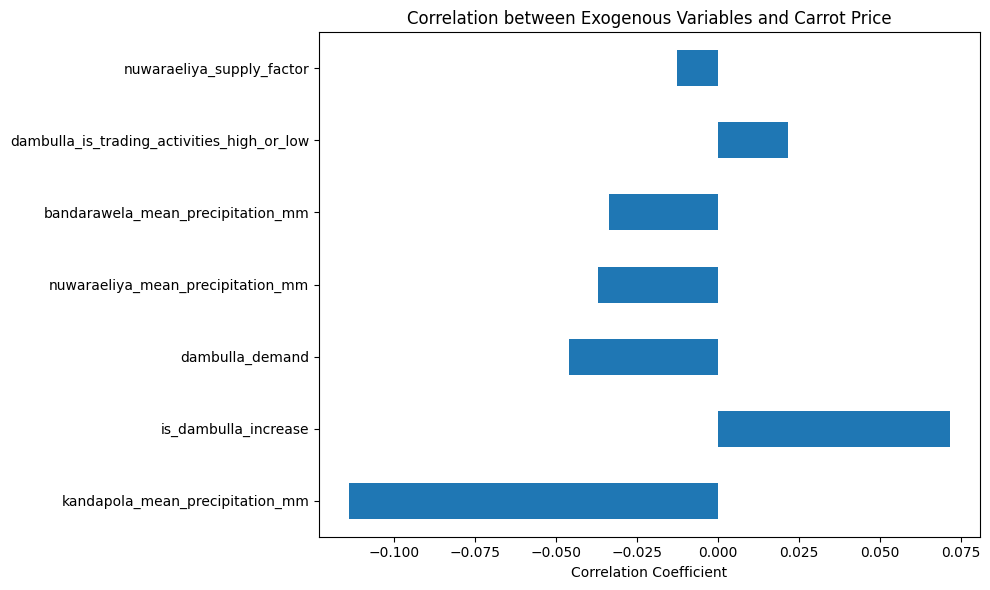

In [ ]:
# Check stationarity of target variable
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"\nStationarity Test for {name}:")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    if result[1] <= 0.05:
        print("=======Series is stationary======")
        return True
    else:
        print("========Series is not stationary==========")
        return False

# Test stationarity of target
target_stationary = check_stationarity(endog, target_var)

# Correlation analysis between target and exogenous variables
print("\nCorrelation with target variable:")
correlations = exog.corrwith(endog).sort_values(key=abs, ascending=False)
for var, corr in correlations.items():
    print(f"{var}: {corr:.4f}")

# Visualize correlations
plt.figure(figsize=(10, 6))
correlations.plot(kind='barh')
plt.title('Correlation between Exogenous Variables and Carrot Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Cell 5: Train-Test Split

In [ ]:
# Split data (80% training, 20% testing)
train_size = int(len(clean_data) * 0.8)

# Split both target and exogenous variables
endog_train = endog[:train_size]
endog_test = endog[train_size:]
exog_train = exog[:train_size]
exog_test = exog[train_size:]

print("Data Split Summary:")
print(f"Total observations: {len(clean_data)}")
print(f"Training set: {len(endog_train)} observations ({len(endog_train)/len(clean_data)*100:.1f}%)")
print(f"Test set: {len(endog_test)} observations ({len(endog_test)/len(clean_data)*100:.1f}%)")
print(f"Training period: {endog_train.index.min().date()} to {endog_train.index.max().date()}")
print(f"Test period: {endog_test.index.min().date()} to {endog_test.index.max().date()}")

# Display first few rows of exogenous variables
print("\nExogenous variables sample (first 5 training rows):")
print(exog_train.head())

Data Split Summary:
Total observations: 2017
Training set: 1613 observations (80.0%)
Test set: 404 observations (20.0%)
Training period: 2020-01-01 to 2024-06-02
Test period: 2024-06-03 to 2025-07-11

Exogenous variables sample (first 5 training rows):
            nuwaraeliya_mean_precipitation_mm  \
date                                            
2020-01-01                               0.18   
2020-01-02                               0.71   
2020-01-03                               1.11   
2020-01-04                               0.76   
2020-01-05                               0.30   

            kandapola_mean_precipitation_mm  \
date                                          
2020-01-01                             1.24   
2020-01-02                             3.16   
2020-01-03                             0.11   
2020-01-04                             1.07   
2020-01-05                             0.13   

            bandarawela_mean_precipitation_mm  nuwaraeliya_supply_factor 

Cell 6: Scale Exogenous Variables (Optional but Recommended)

In [ ]:
# Standardize exogenous variables for better numerical stability
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    index=exog_train.index,
    columns=exog_train.columns
)

exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    index=exog_test.index,
    columns=exog_test.columns
)

print("Exogenous variables scaled successfully!")
print("\nScaled training data summary:")
print(exog_train_scaled.describe())

Exogenous variables scaled successfully!

Scaled training data summary:
       nuwaraeliya_mean_precipitation_mm  kandapola_mean_precipitation_mm  \
count                       1.613000e+03                     1.613000e+03   
mean                        4.405101e-17                     9.691221e-17   
std                         1.000310e+00                     1.000310e+00   
min                        -6.343327e-01                    -7.162557e-01   
25%                        -5.289300e-01                    -6.239455e-01   
50%                        -3.683165e-01                    -3.872778e-01   
75%                         5.831327e-02                     2.284511e-01   
max                         8.114087e+00                     9.461438e+00   

       bandarawela_mean_precipitation_mm  nuwaraeliya_supply_factor  \
count                       1.613000e+03               1.613000e+03   
mean                       -1.541785e-17              -2.863315e-17   
std                  

Cell 7: Fit SARIMAX Model (Multivariate ARIMA)

In [ ]:
# Start with ARIMA(1,0,1) with exogenous variables
# You can tune these parameters later
order = (1, 0, 1)  # (p, d, q)

print(f"Fitting SARIMAX model with order {order}...")
print(f"Using {len(exog_variables)} exogenous variables")

# Fit the model
try:
    model = SARIMAX(
        endog_train,
        exog=exog_train_scaled,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)

    print("======== Model fitted successfully!=========")
    print("\nModel Summary:")
    print(fitted_model.summary())

except Exception as e:
    print(f" ===== Model fitting failed: {e} ======")
    print("Trying with different parameters...")

Fitting SARIMAX model with order (1, 0, 1)...
Using 7 exogenous variables
======== Model fitted successfully!=========

Model Summary:
                               SARIMAX Results                                
Dep. Variable:           carrot_price   No. Observations:                 1613
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8268.316
Date:                Sat, 23 Aug 2025   AIC                          16556.632
Time:                        11:42:38   BIC                          16610.478
Sample:                             0   HQIC                         16576.620
                               - 1613                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
nuwaraeliya

Cell 8: Generate Forecasts

In [ ]:
# Generate predictions on test set
print("Generating forecasts...")

try:
    # Get forecasts with confidence intervals
    forecast_result = fitted_model.get_forecast(
        steps=len(endog_test),
        exog=exog_test_scaled
    )

    forecast = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()

    print(f"====== Generated {len(forecast)} forecasts =======")

    # Display first few predictions
    print("\nFirst 5 predictions:")
    for i in range(min(5, len(forecast))):
        actual = endog_test.iloc[i]
        pred = forecast.iloc[i]
        date = endog_test.index[i].date()
        print(f"{date}: Actual={actual:.2f}, Predicted={pred:.2f}, Error={actual-pred:.2f}")

except Exception as e:
    print(f" ========Forecasting failed: {e}=====")

Generating forecasts...
====== Generated 404 forecasts =======

First 5 predictions:
2024-06-03: Actual=140.00, Predicted=138.54, Error=1.46
2024-06-04: Actual=150.00, Predicted=138.85, Error=11.15
2024-06-05: Actual=145.00, Predicted=102.80, Error=42.20
2024-06-06: Actual=145.00, Predicted=117.33, Error=27.67
2024-06-07: Actual=185.00, Predicted=131.69, Error=53.31


Cell 9: Calculate Accuracy Metrics

In [ ]:
# Calculate comprehensive accuracy metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)

    # MAPE (handle division by zero)
    def safe_mape(actual, predicted):
        # Reset index to ensure alignment for boolean mask
        actual_reset = actual.reset_index(drop=True)
        predicted_reset = predicted.reset_index(drop=True)
        mask = actual_reset != 0
        return np.mean(np.abs((actual_reset[mask] - predicted_reset[mask]) / actual_reset[mask])) * 100

    mape = safe_mape(actual, predicted)

    # MASE
    def calculate_mase(actual, predicted, train_series):
        n = len(train_series)
        if n > 1:
            d = np.abs(np.diff(train_series)).sum() / (n - 1)
            if d != 0:
                errors = np.abs(actual - predicted)
                return errors.mean() / d
        return np.nan

    mase = calculate_mase(actual, predicted, endog_train)

    return mse, rmse, mae, mape, mase

# Calculate metrics for multivariate ARIMA
mse, rmse, mae, mape, mase = calculate_metrics(endog_test, forecast)

print("=" * 60)
print("MULTIVARIATE ARIMA (SARIMAX) ACCURACY EVALUATION")
print("=" * 60)
print(f"Mean Squared Error (MSE):           {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):     {rmse:.4f}")
print(f"Mean Absolute Error (MAE):          {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Scaled Error (MASE):  {mase:.4f}")
print("=" * 60)

# Compare with univariate ARIMA results
print("\nCOMPARISON WITH UNIVARIATE ARIMA:")
print("Univariate ARIMA RMSE: 230.00")
print(f"Multivariate ARIMA RMSE: {rmse:.2f}")

if rmse < 230:
    improvement = ((230 - rmse) / 230) * 100
    print(f"======= Improvement: {improvement:.1f}% reduction in RMSE =========")
else:
    degradation = ((rmse - 230) / 230) * 100
    print(f" =========== Performance degraded: {degradation:.1f}% increase in RMSE ======")

MULTIVARIATE ARIMA (SARIMAX) ACCURACY EVALUATION
Mean Squared Error (MSE):           132099.6453
Root Mean Squared Error (RMSE):     363.4551
Mean Absolute Error (MAE):          293.5442
Mean Absolute Percentage Error (MAPE): 88.80%
Mean Absolute Scaled Error (MASE):  nan

COMPARISON WITH UNIVARIATE ARIMA:
Univariate ARIMA RMSE: 230.00
Multivariate ARIMA RMSE: 363.46
 =========== Performance degraded: 58.0% increase in RMSE ======


In [ ]:
# Debug Cell: Check data dimensions and alignment
print("="*60)
print("DIMENSION DEBUGGING")
print("="*60)

print("SHAPES:")
print(f"endog_test shape: {endog_test.shape}")
print(f"forecast shape: {forecast.shape if hasattr(forecast, 'shape') else len(forecast)}")
print(f"forecast_ci shape: {forecast_ci.shape if hasattr(forecast_ci, 'shape') else len(forecast_ci)}")

print(f"\nINDEX INFORMATION:")
print(f"endog_test index length: {len(endog_test.index)}")
print(f"endog_test first date: {endog_test.index[0]}")
print(f"endog_test last date: {endog_test.index[-1]}")

print(f"\nFORECAST INFORMATION:")
if hasattr(forecast, 'index'):
    print(f"forecast index length: {len(forecast.index)}")
    print(f"forecast first date: {forecast.index}")
    print(f"forecast last date: {forecast.index[-1]}")

# Check for any data type issues
print(f"\nDATA TYPES:")
print(f"endog_test type: {type(endog_test)}")
print(f"forecast type: {type(forecast)}")

# Find the safe length to use
safe_length = min(len(endog_test), len(forecast))
print(f"\nSAFE LENGTH TO USE: {safe_length}")

DIMENSION DEBUGGING
SHAPES:
endog_test shape: (404,)
forecast shape: (404,)
forecast_ci shape: (404, 2)

INDEX INFORMATION:
endog_test index length: 404
endog_test first date: 2024-06-03 00:00:00
endog_test last date: 2025-07-11 00:00:00

FORECAST INFORMATION:
forecast index length: 404
forecast first date: RangeIndex(start=1613, stop=2017, step=1)
forecast last date: 2016

DATA TYPES:
endog_test type: <class 'pandas.core.series.Series'>
forecast type: <class 'pandas.core.series.Series'>

SAFE LENGTH TO USE: 404


Cell 10: Visualize Results

Test data length: 404
Forecast length: 404
Test index length: 404
Using trimmed length: 404


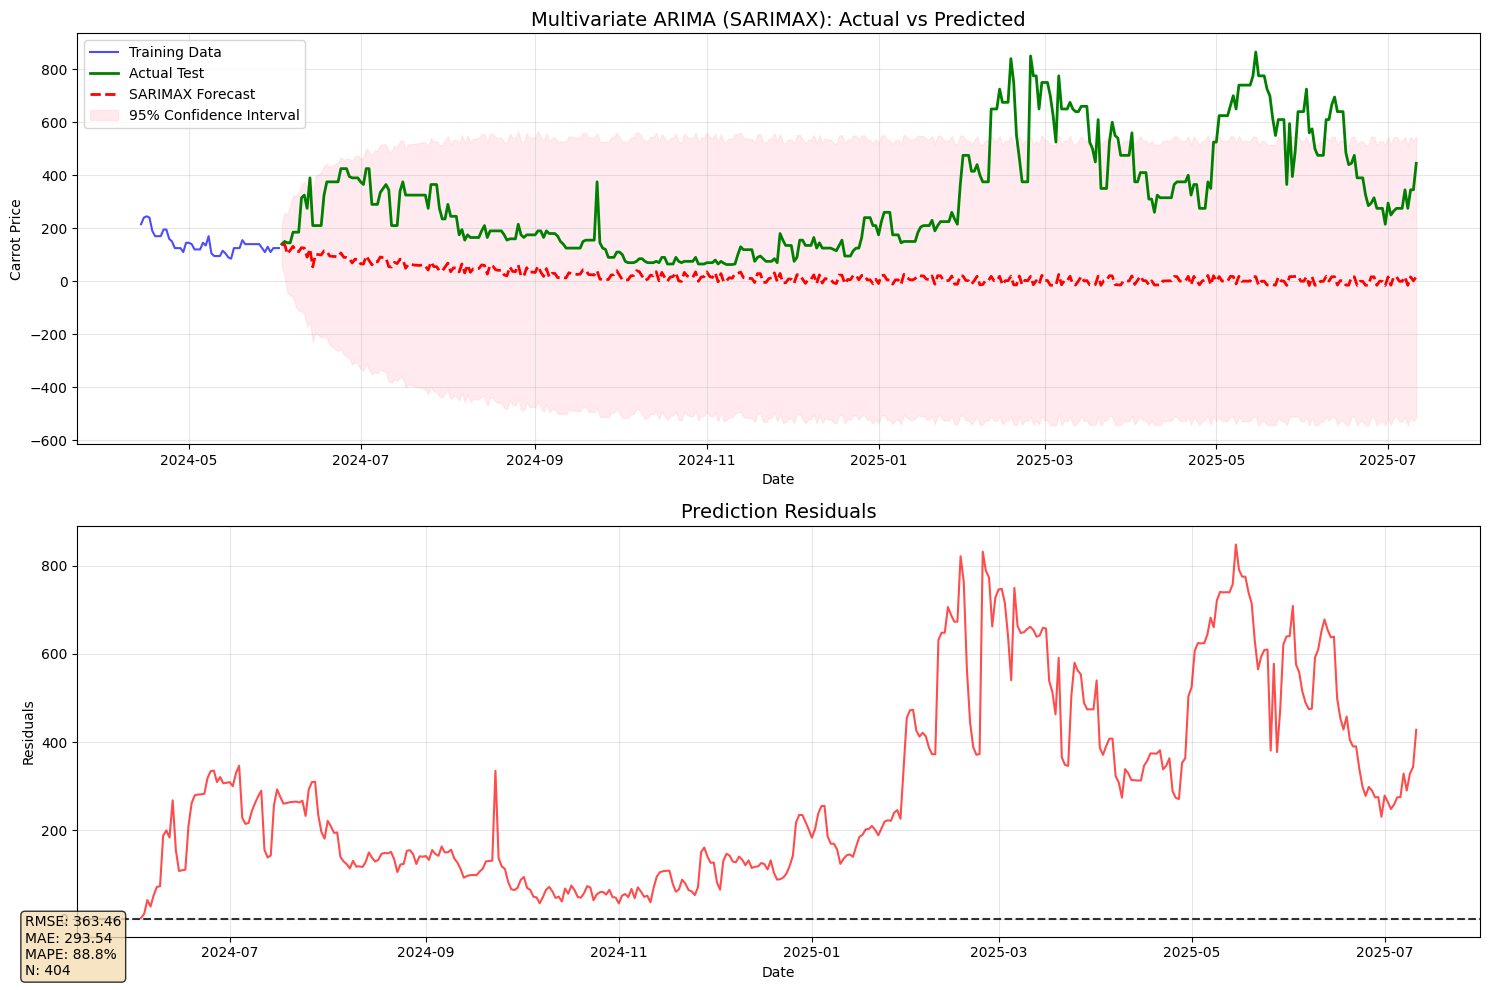


MULTIVARIATE ARIMA ACCURACY METRICS:
RMSE: 363.4551
MAE: 293.5442
MAPE: 88.80%
Observations: 404


In [ ]:
plt.figure(figsize=(15, 10))

# Debug: Check dimensions first
print(f"Test data length: {len(endog_test)}")
print(f"Forecast length: {len(forecast)}")
print(f"Test index length: {len(endog_test.index)}")

# Ensure matching lengths
min_length = min(len(endog_test), len(forecast))
endog_test_trimmed = endog_test.iloc[:min_length]
forecast_trimmed = forecast.iloc[:min_length]

print(f"Using trimmed length: {min_length}")

# Main plot: Actual vs Predicted
plt.subplot(2, 1, 1)
# Plot last 50 training points for context
plt.plot(endog_train[-50:].index, endog_train[-50:],
         label='Training Data', color='blue', alpha=0.7)
plt.plot(endog_test_trimmed.index, endog_test_trimmed,
         label='Actual Test', color='green', linewidth=2)
plt.plot(endog_test_trimmed.index, forecast_trimmed,
         label='SARIMAX Forecast', color='red', linestyle='--', linewidth=2)

# Add confidence intervals (only if available)
try:
    forecast_ci_trimmed = forecast_ci.iloc[:min_length]
    plt.fill_between(endog_test_trimmed.index,
                     forecast_ci_trimmed.iloc[:, 0],
                     forecast_ci_trimmed.iloc[:, 1],
                     color='pink', alpha=0.3, label='95% Confidence Interval')
except:
    print("Confidence intervals not plotted due to dimension issues")

plt.title('Multivariate ARIMA (SARIMAX): Actual vs Predicted', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Carrot Price')
plt.legend()
plt.grid(True, alpha=0.3)

# ✅ FIXED: Residuals plot using .values to avoid index alignment issues
plt.subplot(2, 1, 2)
residuals = endog_test_trimmed.values - forecast_trimmed.values  # Use .values!
plt.plot(endog_test_trimmed.index, residuals, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
plt.title('Prediction Residuals', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Calculate and display metrics using numpy arrays
rmse = np.sqrt(mean_squared_error(endog_test_trimmed.values, forecast_trimmed.values))
mae = mean_absolute_error(endog_test_trimmed.values, forecast_trimmed.values)

# Calculate MAPE safely
def safe_mape(actual, predicted):
    mask = actual != 0
    if mask.any():
        return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    return np.nan

mape = safe_mape(endog_test_trimmed.values, forecast_trimmed.values)

textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.1f}%\nN: {min_length}'
plt.figtext(0.02, 0.02, textstr, fontsize=10,
            bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MULTIVARIATE ARIMA ACCURACY METRICS:")
print("="*50)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Observations: {min_length}")